<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Script-to-connect-to-postgresql" data-toc-modified-id="Script-to-connect-to-postgresql-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Script to connect to postgresql</a></span></li><li><span><a href="#Using-the-script-to-get-database-dependencies" data-toc-modified-id="Using-the-script-to-get-database-dependencies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using the script to get database dependencies</a></span></li><li><span><a href="#Output-of-database-dependencies" data-toc-modified-id="Output-of-database-dependencies-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output of database dependencies</a></span></li></ul></div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Script to connect to postgresql

In [1]:
%%writefile postgres-deps.py

"""
Script to create postgres dependencies png image from given postgres database.

Example:
database: dvdrental
dbuser: postgres
dbpass: your passoword of postgre
output: deps.png
python: /Users/poudel/miniconda3/envs/dataSc/bin/python
        (where psycopg2 is installed)

Usage:
======
python postgres-deps.py --dbname dvdrental --dbuser postgres --dbpass MYPASSWORD | dot -Tpng > deps.png

"""


from optparse import OptionParser, OptionGroup

import psycopg2
import sys


def writedeps(cursor, tbl):
    sql = """SELECT
        tc.constraint_name, tc.table_name, kcu.column_name,
        ccu.table_name AS foreign_table_name,
        ccu.column_name AS foreign_column_name
    FROM
        information_schema.table_constraints AS tc
    JOIN information_schema.key_column_usage AS kcu ON
        tc.constraint_name = kcu.constraint_name
    JOIN information_schema.constraint_column_usage AS ccu ON
        ccu.constraint_name = tc.constraint_name
    WHERE constraint_type = 'FOREIGN KEY' AND tc.table_name = '%s'"""
    cursor.execute(sql % tbl)
    for row in cursor.fetchall():
        constraint, table, column, foreign_table, foreign_column = row
        print('"%s" -> "%s" [label="%s"];' % (tbl, foreign_table, constraint))


def get_tables(cursor):
    cursor.execute("SELECT tablename FROM pg_tables WHERE schemaname='public'")
    for row in cursor.fetchall():
        yield row[0]


def main():
    parser = OptionParser()

    group = OptionGroup(parser, "Database Options")
    group.add_option("--dbname", action="store", dest="dbname",
            help="The database name.")
    group.add_option("--dbhost", action="store", dest="dbhost",
            default="localhost",  help="The database host.")
    group.add_option("--dbuser", action="store", dest="dbuser",
            help="The database username.")
    group.add_option("--dbpass", action="store", dest="dbpass",
            help="The database password.")
    parser.add_option_group(group)

    (options, args) = parser.parse_args()

    if not options.dbname:
        print("Please supply a database name, see --help for more info.")
        sys.exit(1)

    try:
        conn = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s'"
            % (options.dbname, options.dbuser, options.dbhost, options.dbpass))
    except psycopg2.OperationalError as e:
        print("Failed to connect to database,", end=' ')
        print("perhaps you need to supply auth details:\n %s" % str(e))
        print("Use --help for more info.")
        sys.exit(1)

    cursor = conn.cursor()

    print("Digraph F {\n")
    print('ranksep=1.0; size="18.5, 15.5"; rankdir=LR;')
    for i in get_tables(cursor):
        writedeps(cursor, i)
    print("}")

    sys.exit(0)


if __name__ == "__main__":
    main()

Overwriting postgres-deps.py


# Using the script to get database dependencies

In [3]:
import os
import yaml

with open( os.path.expanduser('~') + "/.postgres_conf.yml", 'r') as stream:
    try:
        yaml_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

dbname = 'dvdrental'
dbuser = 'postgres'
dbpass = yaml_dict['password']
dbport = yaml_dict['port']

In [4]:
! /Users/poudel/miniconda3/envs/dataSc/bin/python postgres-deps.py --dbname $dbname --dbuser $dbuser --dbpass $dbpass | dot -Tpng > dvdrental_dependencies.png

# Output of database dependencies

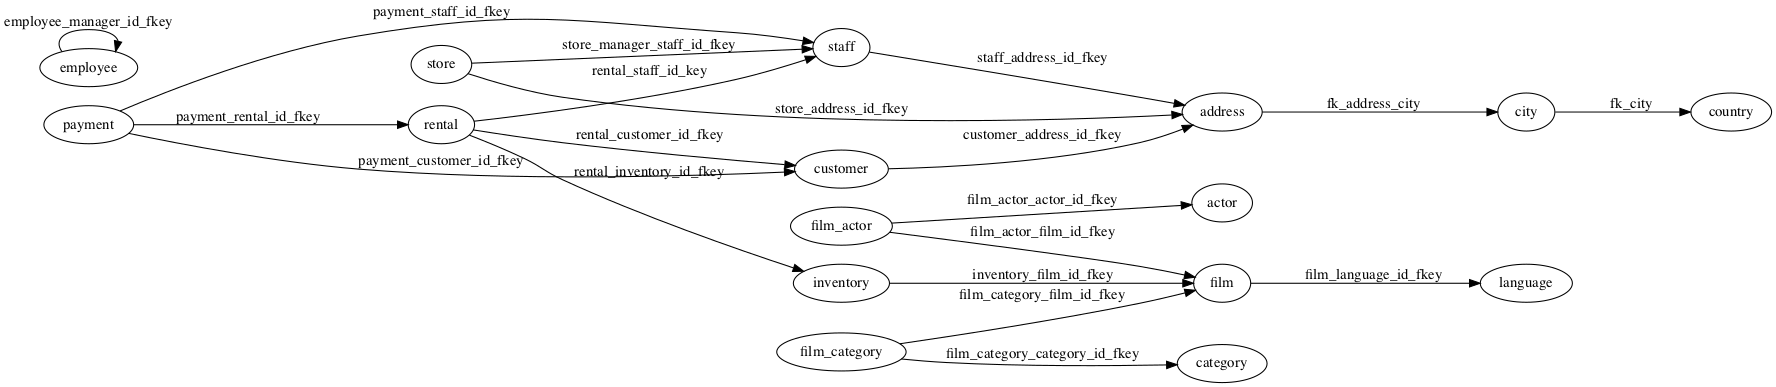

In [5]:
from IPython.display import Image

Image('dvdrental_dependencies.png',unconfined=True)